In [1]:
from gensim.models import Doc2Vec
import smart_open
from gensim.models.doc2vec import TaggedDocument

In [2]:
import multiprocessing
from tqdm import tqdm
cores = multiprocessing.cpu_count()

In [3]:
import numpy as np

In [4]:
import pandas as pd
df=pd.read_json("un_speeches_tokenised.json",orient='records',compression='infer')

In [5]:
df.columns

Index(['doc', 'Year', 'Session', 'ISO Code', 'Country',
       'Name of Person Speaking', 'Post', 'Language', 'Notes', 'sent_split',
       'word_split', 'count_speech_words', 'count_speech_sent'],
      dtype='object')

In [6]:
speech19=df[df['Year']==1991.0]


In [7]:
usa19=speech19[speech19['ISO Code']=='USA']['doc'].values
alb19=speech19[speech19['ISO Code']=='ALB']['doc'].values
cuba19=speech19[speech19['ISO Code']=='CUB']['doc'].values
ven19=speech19[speech19['ISO Code']=='VEN']['doc'].values

In [8]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

In [9]:
text1= NER(str(usa19))
displacy.render(text1,style="ent",jupyter=True)

In [10]:
text1= NER(str(alb19))
displacy.render(text1,style="ent",jupyter=True)

In [11]:
text1= NER(str(cuba19))
displacy.render(text1,style="ent",jupyter=True)

In [12]:
text1= NER(str(ven19))
displacy.render(text1,style="ent",jupyter=True)

In [13]:
countries=set()
for i in speech19['doc']:
    text= NER(str(i))
    for word in text.ents:
        country,gpe=word.text,word.label_
        if gpe=="GPE":
            countries.add(country)
       
    

In [14]:
countries
def removegpe(x):
    l=[]
    for i in x:
        if i not in countries:
            l.append(i)
    return l
            

In [15]:
speech19['word_split_withoutgpe']=speech19['word_split'].apply(removegpe)

<ipython-input-15-ac26de496abb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech19['word_split_withoutgpe']=speech19['word_split'].apply(removegpe)


In [16]:
for i in speech19['word_split'][:10]:
    print(len(i))

4714
2972
3848
2981
2968
3369
4811
2913
3799
3634


In [17]:
for i in speech19['word_split_withoutgpe'][:10]:
    print(len(i))

4577
2899
3746
2922
2897
3267
4664
2828
3694
3553


In [18]:
doc19=speech19['word_split_withoutgpe']

In [19]:
# train_tagged = TaggedDocument(words=doc19, tags=[i for i in range(len(doc19))])
# # train_tagged = train.apply(
# #     lambda r: TaggedDocument(words=tokenize_text(r['description']), tags=[r.issue]), axis=1)
i=0
train_tagged = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc19)]

In [20]:
train_tagged

[TaggedDocument(words=['\ufeffAt', 'the', 'outset', 'I', 'wish', 'to', 'convey', 'to', 'Ambassador', 'Shihabi', 'my', 'warmest', 'congratulations', 'on', 'his', 'election', 'as', 'President', 'of', 'the', 'General', 'Assembly', 'at', 'its', 'forty-sixth', 'session', ',', 'and', 'to', 'wish', 'him', 'every', 'success', 'in', 'carrying', 'out', 'his', 'high', 'and', 'responsible', 'duties', '.', 'It', 'is', 'a', 'source', 'of', 'satisfaction', 'that', 'an', 'experienced', 'diplomat', 'of', 'such', 'high', 'calibre', 'and', 'distinguished', 'qualities', 'has', 'been', 'elected', 'to', 'this', 'prestigious', 'post', '.', 'The', 'fact', 'that', 'the', 'President', 'comes', 'from', 'Saudi', 'Arabia', ',', 'a', 'country', 'so', 'close', 'to', 'the', 'hearts', 'of', 'all', 'Muslims', ',', 'has', 'a', 'special', 'significance', 'for', 'us', '.', 'I', 'should', 'like', 'also', 'to', 'express', 'our', 'appreciation', 'for', 'the', 'valuable', 'services', 'of', 'his', 'predecessor', ',', 'His', 'E

In [21]:

# model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow = Doc2Vec(seed=42,dm=0, vector_size=50, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow

In [22]:

# model_dbow.build_vocab(train_tagged)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

100%|█████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 80928.69it/s]


In [23]:

from sklearn import utils
for epoch in range(30):
    model_dbow.train([x for x in tqdm(train_tagged)], total_examples=len(train_tagged), epochs=1)
#     model_dbow.alpha -= 0.002
#     model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 161934.52it/s]


In [24]:
model_dbow.save("doc2vec_new_without_gpe_1991.model")

In [25]:

model = Doc2Vec.load("doc2vec_new_without_gpe_1991.model")

In [26]:

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    model.random.seed(42)
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [27]:
_, X_train = vec_for_learning(model, train_tagged)

In [28]:
X_train=np.array(X_train)

In [29]:
X_train[0]

array([ 1.5352181 ,  0.47537202,  1.0268655 , -0.52372503, -0.39236456,
       -0.34399423,  0.35282004,  0.938633  , -1.2750431 , -0.266257  ,
        0.12658006,  1.1004926 ,  0.07192452, -0.266203  ,  0.78535855,
        0.7447103 , -0.34523982, -0.5086428 , -0.39707994,  0.9669271 ,
        0.4539635 , -0.13687573,  0.00755382, -1.5130975 , -0.53766453,
       -0.68560517,  0.75225824, -0.09707366, -0.3681027 ,  0.5327916 ,
       -0.5152757 , -0.4369559 , -0.33825007, -0.9810752 , -0.18012679,
        0.33627856, -0.7248749 ,  0.2443991 ,  0.4159517 , -0.82797337,
       -0.19304842,  0.54785913, -0.01445672, -0.09028905,  0.48939922,
       -0.05387924, -0.7887584 ,  0.1816236 ,  1.1679525 , -1.4016337 ],
      dtype=float32)

In [30]:
X_train[0]

array([ 1.5352181 ,  0.47537202,  1.0268655 , -0.52372503, -0.39236456,
       -0.34399423,  0.35282004,  0.938633  , -1.2750431 , -0.266257  ,
        0.12658006,  1.1004926 ,  0.07192452, -0.266203  ,  0.78535855,
        0.7447103 , -0.34523982, -0.5086428 , -0.39707994,  0.9669271 ,
        0.4539635 , -0.13687573,  0.00755382, -1.5130975 , -0.53766453,
       -0.68560517,  0.75225824, -0.09707366, -0.3681027 ,  0.5327916 ,
       -0.5152757 , -0.4369559 , -0.33825007, -0.9810752 , -0.18012679,
        0.33627856, -0.7248749 ,  0.2443991 ,  0.4159517 , -0.82797337,
       -0.19304842,  0.54785913, -0.01445672, -0.09028905,  0.48939922,
       -0.05387924, -0.7887584 ,  0.1816236 ,  1.1679525 , -1.4016337 ],
      dtype=float32)

In [31]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  random_state=42, perplexity=3).fit_transform(X_train)
X_embedded.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(162, 2)

In [32]:
viz=pd.DataFrame(X_embedded,columns=["dim1","dim2"])

In [33]:
speech19['ISO Code']

2886    AFG
2887    AGO
2888    ALB
2889    ARE
2890    ARG
       ... 
3043    WSM
3044    YEM
3045    YUG
3046    ZMB
3047    ZWE
Name: ISO Code, Length: 162, dtype: object

In [34]:
viz['country_code']=speech19['ISO Code'].values
viz['country']=speech19['Country'].values

In [35]:
viz.columns

Index(['dim1', 'dim2', 'country_code', 'country'], dtype='object')

In [36]:
viz

dim1       dim2 country_code               country
0     5.813349  27.826468          AFG           Afghanistan
1   -16.721272 -26.762171          AGO                Angola
2    15.791579 -28.495255          ALB               Albania
3    34.466499  33.402889          ARE  United Arab Emirates
4    -0.620920 -36.741543          ARG             Argentina
..         ...        ...          ...                   ...
157 -13.856516  -7.777095          WSM        Western Sahara
158  24.013079  22.502235          YEM                 Yemen
159  14.209652 -29.733023          YUG            Yugoslavia
160 -10.388215  18.703287          ZMB                Zambia
161 -16.476454  13.418642          ZWE              Zimbabwe

[162 rows x 4 columns]

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
#         print(data[text_column][line])   
        p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', weight='semibold')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1

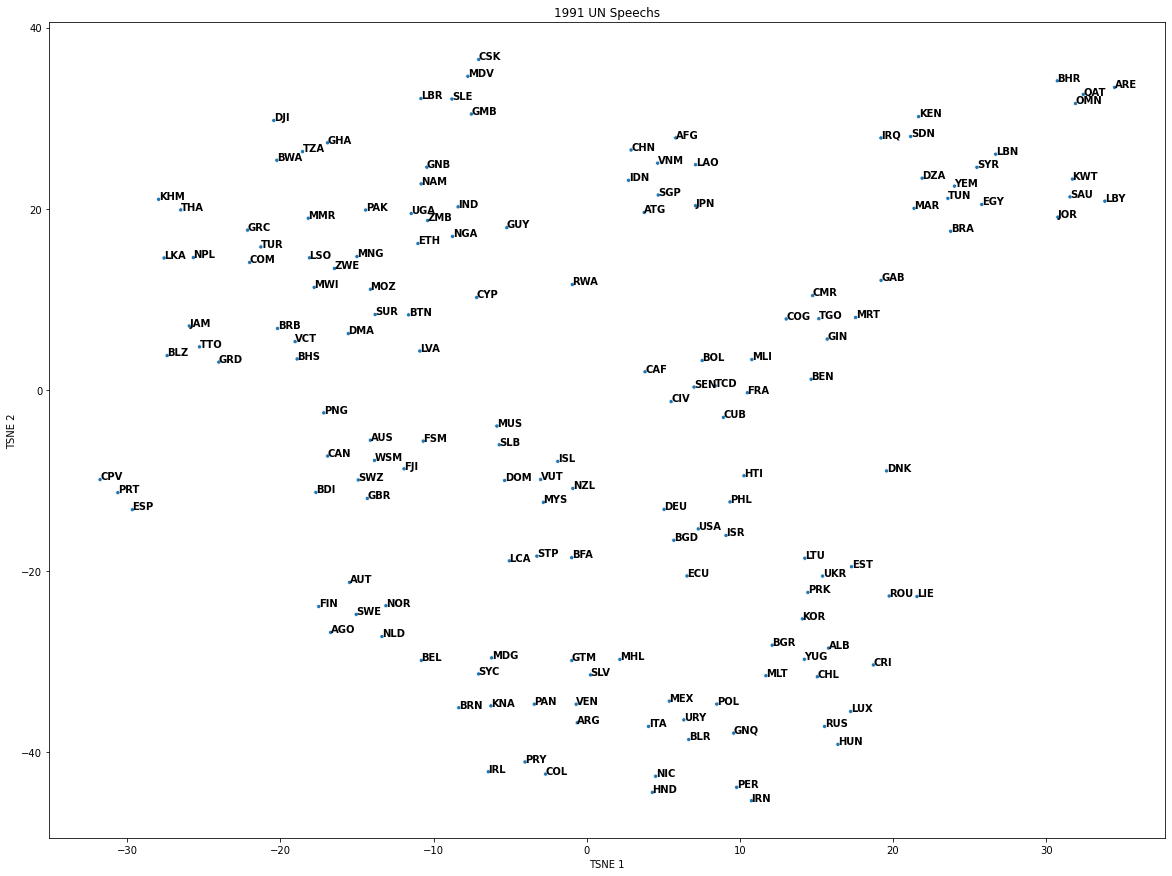

In [38]:
plt.figure(figsize=(20,15))
scatter_text('dim1', 'dim2', 'country_code',
             data = viz, 
             title = '1991 UN Speechs', 
             xlabel = 'TSNE 1',
             ylabel = 'TSNE 2')

In [39]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
speech19[['ISO Code','Country']].head(200)

ISO Code                                 Country
2886      AFG                             Afghanistan
2887      AGO                                  Angola
2888      ALB                                 Albania
2889      ARE                    United Arab Emirates
2890      ARG                               Argentina
2891      ATG                     Antigua and Barbuda
2892      AUS                               Australia
2893      AUT                                 Austria
2894      BDI                                 Burundi
2895      BEL                                 Belgium
2896      BEN                                   Benin
2897      BFA                            Burkina Faso
2898      BGD                              Bangladesh
2899      BGR                                Bulgaria
2900      BHR                                 Bahrain
2901      BHS                                 Bahamas
2902      BLR                                 Belarus
2903      BLZ                                  Belize
2904      BOL         Bolivia, Plurinational State of
2905      BRA                                  Brazil
2906      BRB                                Barbados
2907      BRN                       Brunei Darussalam
2908      BTN                                  Bhutan
2909      BWA                                Botswana
2910      CAF                Central African Republic
2911      CAN                                  Canada
2912      CHL                                   Chile
2913      CHN                                   China
2914      CIV                           Côte d'Ivoire
2915      CMR                                Cameroon
2916      COG                                   Congo
2917      COL                                Colombia
2918      COM                                 Comoros
2919      CPV                              Cape Verde
2920      CRI                              Costa Rica
2921      CSK                          Czechoslovakia
2922      CUB                                    Cuba
2923      CYP                                  Cyprus
2924      DEU                                 Germany
2925      DJI                                Djibouti
2926      DMA                                Dominica
2927      DNK                                 Denmark
2928      DOM                      Dominican Republic
2929      DZA                                 Algeria
2930      ECU                                 Ecuador
2931      EGY                                   Egypt
2932      ESP                                   Spain
2933      EST                                 Estonia
2934      ETH                                Ethiopia
2935      FIN                                 Finland
2936      FJI                                    Fiji
2937      FRA                                  France
2938      FSM         Micronesia, Federated States of
2939      GAB                                   Gabon
2940      GBR                          United Kingdom
2941      GHA                                   Ghana
2942      GIN                                  Guinea
2943      GMB                                  Gambia
2944      GNB                           Guinea-Bissau
2945      GNQ                       Equatorial Guinea
2946      GRC                                  Greece
2947      GRD                                 Grenada
2948      GTM                               Guatemala
2949      GUY                                  Guyana
2950      HND                                Honduras
2951      HTI                                   Haiti
2952      HUN                                 Hungary
2953      IDN                               Indonesia
2954      IND                                   India
2955      IRL                                 Ireland
2956      IRN               Iran, Islamic Republic of
2957      IRQ                                    Iraq
2958      ISL                                 Iceland
2959     

In [40]:
import plotly.express as px

In [41]:
fig = px.scatter(viz, x="dim1", y="dim2",color="country",
                  hover_data=['country_code','country'],title="1991 UNGA speeches_without_GPE",text="country_code",width=1700,height=1200)
fig.show()

In [42]:
fig.write_html("speechs_1991_Without_GPE_new.html")

In [43]:
import scipy.cluster.hierarchy as hac 

In [44]:
z = hac.linkage(viz[['dim1','dim2']], method='complete') 
labels = hac.fcluster(z, 1, criterion="distance")
labels = hac.fcluster(z, 30, criterion="distance")

In [45]:
labels

array([8, 2, 1, 5, 2, 8, 6, 2, 6, 2, 3, 4, 4, 1, 5, 7, 1, 7, 3, 5, 7, 2,
       9, 9, 3, 6, 1, 8, 3, 3, 3, 2, 9, 7, 1, 8, 3, 9, 4, 9, 9, 4, 6, 5,
       4, 5, 7, 4, 9, 2, 6, 3, 6, 3, 6, 9, 3, 8, 9, 1, 9, 7, 2, 9, 1, 4,
       1, 8, 9, 2, 1, 5, 6, 4, 1, 7, 5, 8, 5, 9, 2, 4, 5, 8, 5, 8, 5, 4,
       4, 9, 9, 4, 1, 9, 5, 2, 8, 1, 2, 3, 1, 9, 9, 9, 3, 6, 9, 6, 9, 9,
       1, 2, 2, 9, 6, 5, 9, 2, 1, 4, 6, 1, 4, 7, 2, 5, 4, 1, 9, 5, 5, 3,
       8, 6, 8, 2, 4, 9, 2, 6, 2, 5, 3, 3, 9, 7, 5, 9, 9, 9, 4, 1, 4, 7,
       2, 8, 6, 6, 5, 1, 9, 9], dtype=int32)

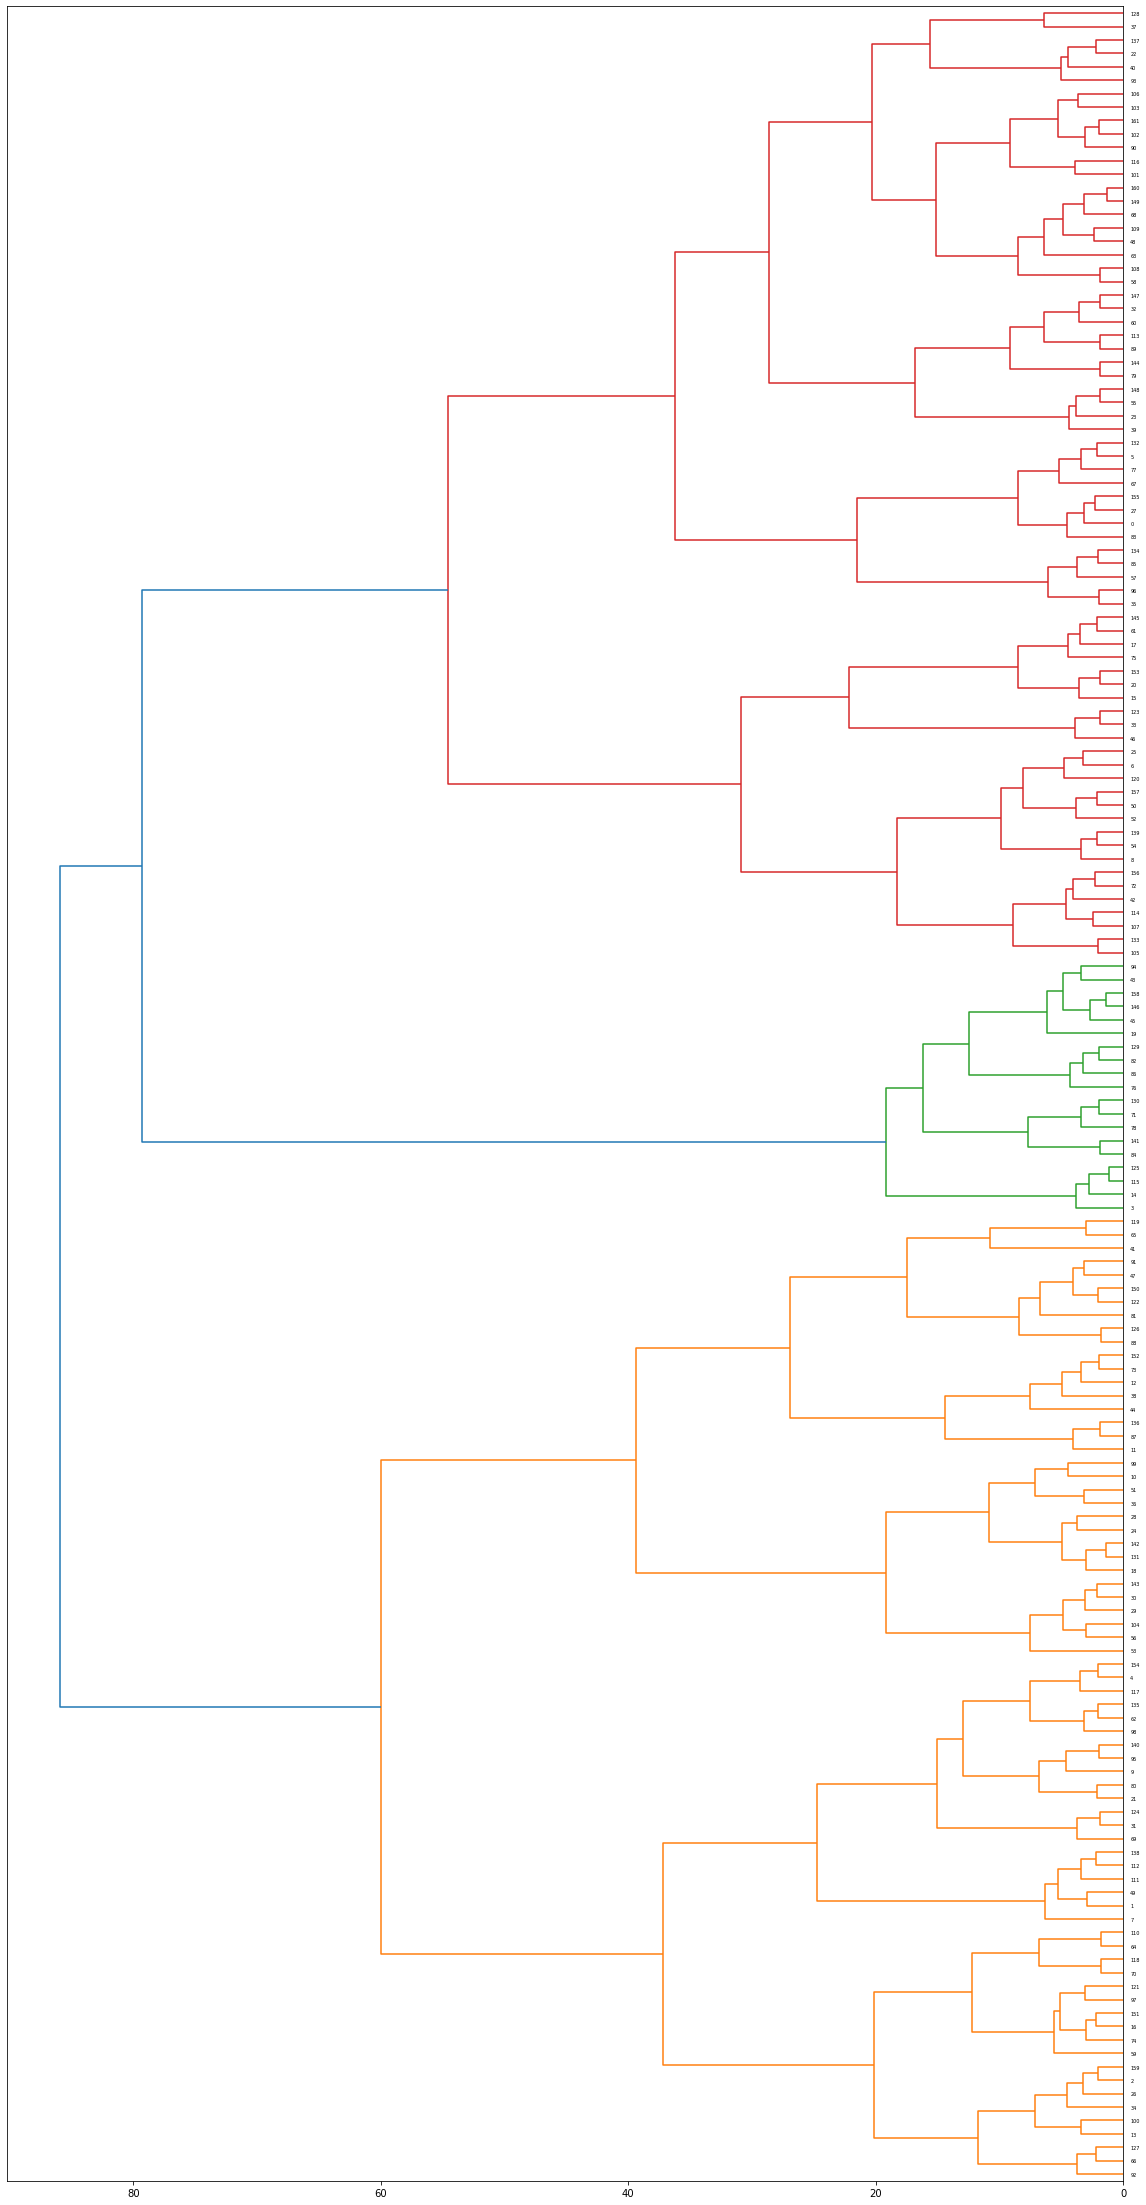

In [46]:
plt.figure(figsize=(20,40))
h=hac.dendrogram(z,orientation='left')
plt.show()

In [47]:
viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [48]:
fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                  hover_data=['country_code','country'],title="1991 UNGA speeches without GPE hierarchy clustering",text="country_code",width=1700,height=1200)
fig.show()

In [49]:
fig.write_html("speechs_1991_Without_GPE_new_labels_dendogram.html")

In [50]:
from sklearn.cluster import KMeans

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Text(0, 0.5, 'Inertia')

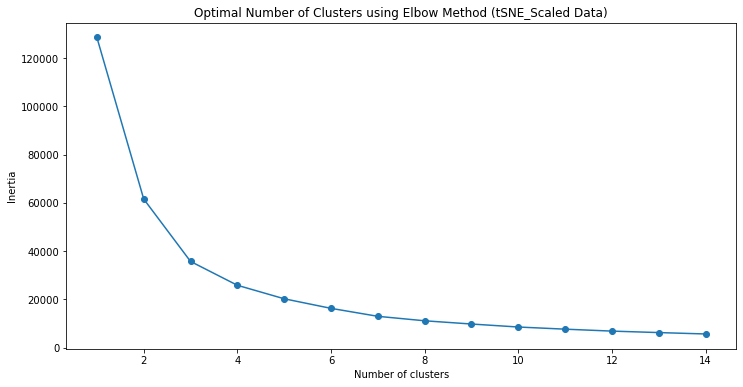

In [51]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(viz[['dim1','dim2']])
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [52]:
viz

dim1       dim2 country_code                                 country     labels
0     5.813349  27.826468          AFG                             Afghanistan  CLUSTER 8
1   -16.721272 -26.762171          AGO                                  Angola  CLUSTER 2
2    15.791579 -28.495255          ALB                                 Albania  CLUSTER 1
3    34.466499  33.402889          ARE                    United Arab Emirates  CLUSTER 5
4    -0.620920 -36.741543          ARG                               Argentina  CLUSTER 2
5     3.749740  19.589092          ATG                     Antigua and Barbuda  CLUSTER 8
6   -14.130745  -5.545899          AUS                               Australia  CLUSTER 6
7   -15.486759 -21.241554          AUT                                 Austria  CLUSTER 2
8   -17.684498 -11.310948          BDI                                 Burundi  CLUSTER 6
9   -10.799370 -29.855659          BEL                                 Belgium  CLUSTER 2
10   14.653576   1.181848          BEN                                   Benin  CLUSTER 3
11   -0.983329 -18.518375          BFA                            Burkina Faso  CLUSTER 4
12    5.687513 -16.597355          BGD                              Bangladesh  CLUSTER 4
13   12.109138 -28.174768          BGR                                Bulgaria  CLUSTER 1
14   30.725012  34.122963          BHR                                 Bahrain  CLUSTER 5
15  -18.910931   3.419964          BHS                                 Bahamas  CLUSTER 7
16    6.661236 -38.590187          BLR                                 Belarus  CLUSTER 1
17  -27.399199   3.787139          BLZ                                  Belize  CLUSTER 7
18    7.536872   3.245319          BOL         Bolivia, Plurinational State of  CLUSTER 3
19   23.762184  17.516870          BRA                                  Brazil  CLUSTER 5
20  -20.190924   6.788689          BRB                                Barbados  CLUSTER 7
21   -8.354625 -35.083782          BRN                       Brunei Darussalam  CLUSTER 2
22  -11.632772   8.288066          BTN                                  Bhutan  CLUSTER 9
23  -20.233812  25.358761          BWA                                Botswana  CLUSTER 9
24    3.806652   2.004076          CAF                Central African Republic  CLUSTER 3
25  -16.916008  -7.296189          CAN                                  Canada  CLUSTER 6
26   15.055875 -31.664043          CHL                                   Chile  CLUSTER 1
27    2.896113  26.491371          CHN                                   China  CLUSTER 8
28    5.509241  -1.290333          CIV                           Côte d'Ivoire  CLUSTER 3
29   14.753431  10.417125          CMR                                Cameroon  CLUSTER 3
30   13.022279   7.835380          COG                                   Congo  CLUSTER 3
31   -2.689312 -42.406799          COL                                Colombia  CLUSTER 2
32  -22.009933  14.080053          COM                                 Comoros  CLUSTER 9
33  -31.778265  -9.899743          CPV                              Cape Verde  CLUSTER 7
34   18.712927 -30.361376          CRI                              Costa Rica  CLUSTER 1
35   -7.050607  36.483280          CSK                          Czechoslovakia  CLUSTER 8
36    8.921475  -3.026728          CUB                                    Cuba  CLUSTER 3
37   -7.185301  10.210959          CYP                                  Cyprus  CLUSTER 9
38    5.048550 -13.180907          DEU                                 Germany  CLUSTER 4
39  -20.434717  29.751911          DJI                                Djibouti  CLUSTER 9
40  -15.569686   6.216053          DMA                                Dominica  CLUSTER 9
41   19.574598  -8.939837          DNK                                 Denmark  CLUSTER 4
42   -5.358205  -9.994971          DOM                      Dominican Republic  CLUSTER 6
43   21.899431  23.377602          DZA            

In [53]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(viz[['dim1','dim2']])
kmeans.labels_

labels=kmeans.predict(viz[['dim1','dim2']])
viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [55]:

fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                  hover_data=['country_code','country'],title="1991 UNGA speeches_without GPE KMEANS CLUSTERS",text="country_code",width=1700,height=1200)
fig.show()

In [56]:
fig.write_html("speechs_1991_Without_GPE_new_labels_kmeans.html")

In [57]:
from sklearn.cluster import DBSCAN
import numpy as np

clustering = DBSCAN(eps=5.5, min_samples=6).fit(viz[['dim1','dim2']])
labels=clustering.labels_

In [58]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7}

In [59]:

viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [60]:
fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                  hover_data=['country_code','country'],title="2019 UNGA speeches without GPE DBSCAN",text="country_code",width=1700,height=1200)
fig.show()

In [61]:
fig.write_html("speechs_1991_Without_GPE_new_labels1.html")

In [62]:
df.columns

Index(['doc', 'Year', 'Session', 'ISO Code', 'Country', 'Name of Person Speaking', 'Post', 'Language', 'Notes', 'sent_split', 'word_split', 'count_speech_words', 'count_speech_sent'], dtype='object')

In [63]:
speech19['labels']=viz['labels'].values

<ipython-input-63-8f92495e96f9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
speech19.shape

(162, 15)

In [65]:
speech19.to_json("un_speeches_1991_labels.json",orient='records',compression='infer')